In [126]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from prophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
std=StandardScaler()
from pmdarima import auto_arima
#pd.set_option('display.float_format', lambda x: '%.6f' %

In [2]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

Saving covid19_dataset.csv to covid19_dataset.csv


In [13]:
covid = pd.read_csv("covid19_dataset.csv")
covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [14]:
covid.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [5]:
#Drop the irrelevant columns
covid.drop(["Province/State", "Lat", "Long", "WHO Region"], axis=1, inplace = True)

In [6]:
covid.head()

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0,0
1,Albania,2020-01-22,0,0,0,0
2,Algeria,2020-01-22,0,0,0,0
3,Andorra,2020-01-22,0,0,0,0
4,Angola,2020-01-22,0,0,0,0


In [7]:
covid["Date"]=pd.to_datetime(covid["Date"])

In [8]:
grouped_country= covid.groupby(["Country/Region","Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [9]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [10]:
#Grouping together cases according to date
datewise_data =covid.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_data["Days Since"]=datewise_data.index-datewise_data.index.min()

In [11]:
#ctive Cases = Number of Confirmed Cases - Number of Recovered Cases - Number of Death Cases
fig=px.bar(x=datewise_data.index,y=datewise_data["Confirmed"]-datewise_data["Recovered"]-datewise_data["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [12]:
datewise_data["WeekOfYear"]=datewise_data.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise_data["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise_data[datewise_data["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise_data[datewise_data["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise_data[datewise_data["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

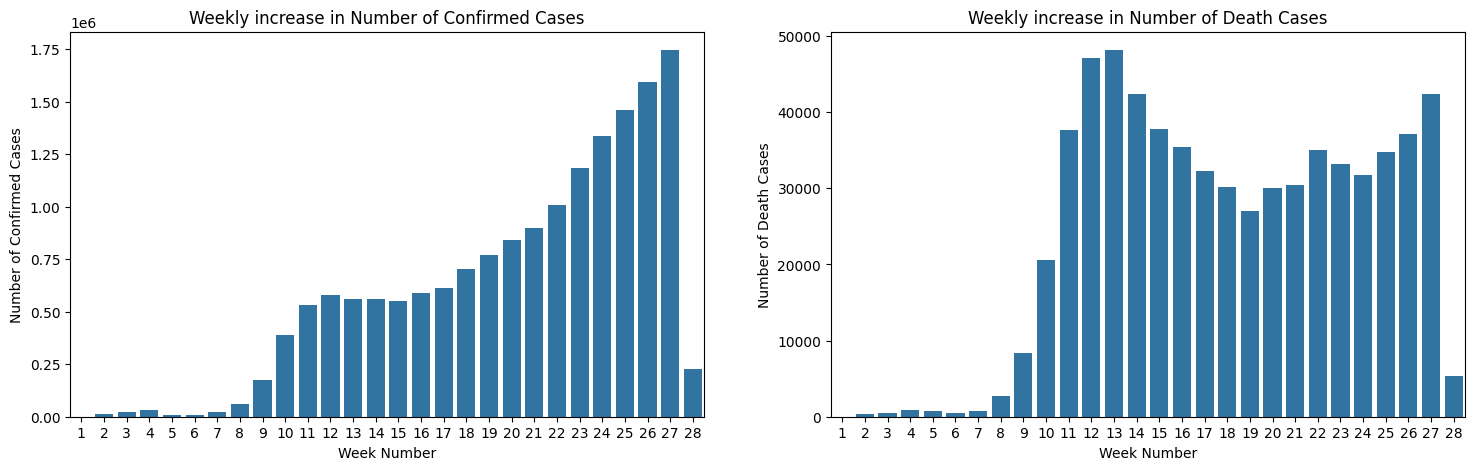

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

In [17]:
#Growth rate for confirmed, recovered and active cases
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [19]:
#Calculating the Mortality Rate and Recovery Rate
datewise_data["Mortality Rate"]=(datewise_data["Deaths"]/datewise_data["Confirmed"])*100
datewise_data["Recovery Rate"]=(datewise_data["Recovered"]/datewise_data["Confirmed"])*100
datewise_data["Active Cases"]=datewise_data["Confirmed"]-datewise_data["Recovered"]-datewise_data["Deaths"]
datewise_data["Closed Cases"]=datewise_data["Recovered"]+datewise_data["Deaths"]

print("Average Mortality Rate",datewise_data["Mortality Rate"].mean())
print("Median Mortality Rate",datewise_data["Mortality Rate"].median())
print("Average Recovery Rate",datewise_data["Recovery Rate"].mean())
print("Median Recovery Rate",datewise_data["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise_data.index, y=(datewise_data["Recovered"]/datewise_data["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise_data.index, y=(datewise_data["Deaths"]/datewise_data["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.860771192198554
Median Mortality Rate 4.848076824165192
Average Recovery Rate 34.34406993903387
Median Recovery Rate 35.67809454972935


In [21]:
#One week rolling difference of confirmed, active and recovered cases
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [23]:
#countrywise Moratality and Recovery Rate
countrywise=covid[covid["Date"]==covid["Date"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [27]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])



In [28]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_recovered,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 Countries with Highest Number of Death Cases in Last 24 Hours')

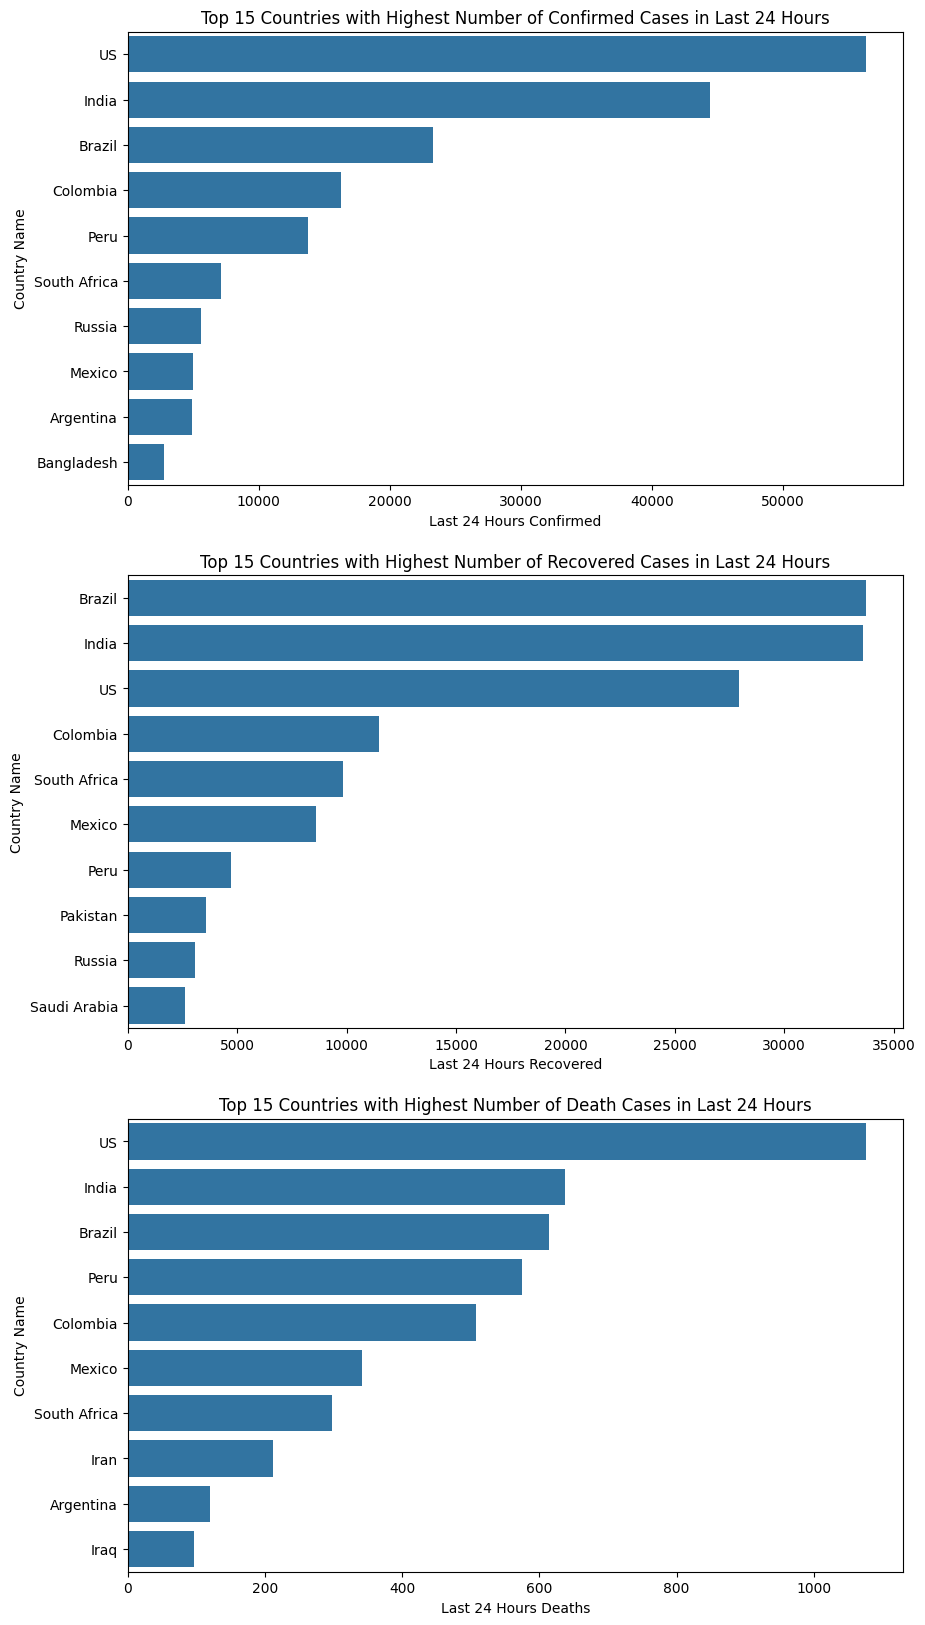

In [37]:
# LAST ONE DAY CHANGE IN THE RECOVED , CONFIRMED AND DEATH CASES PER COUNTRY. Listing out the top 10 countries.

Top_10_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(10)
Top_10_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(10)
Top_10_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(10)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_10_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_10_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 Countries with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_10_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_10_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 Countries with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_10_Deaths_24hr["Last 24 Hours Deaths"],y=Top_10_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 Countries with Highest Number of Death Cases in Last 24 Hours")

In [35]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise_data["Confirmed"].iloc[-1]-datewise_data["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise_data["Recovered"].iloc[-1]-datewise_data["Recovered"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise_data["Deaths"].iloc[-1]-datewise_data["Deaths"].iloc[-2]))*100



In [36]:
#Countrywise propotion of confirmed, recovered and death count
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
0,US,24.634329,16.000756,19.870729
2,India,19.439938,19.240306,11.763620
1,Brazil,10.181513,19.314752,11.338873
13,Colombia,7.130207,6.582180,9.381348
6,Peru,6.015156,2.689795,10.618652
4,South Africa,3.102904,5.639578,5.503232
3,Russia,2.451801,1.762082,1.569714
5,Mexico,2.174569,4.918023,6.315789
19,Argentina,2.138275,1.177966,2.216066
16,Bangladesh,1.212127,1.031365,0.683287


Text(0.5, 1.0, 'Top 10 countries as per Number of Death Cases')

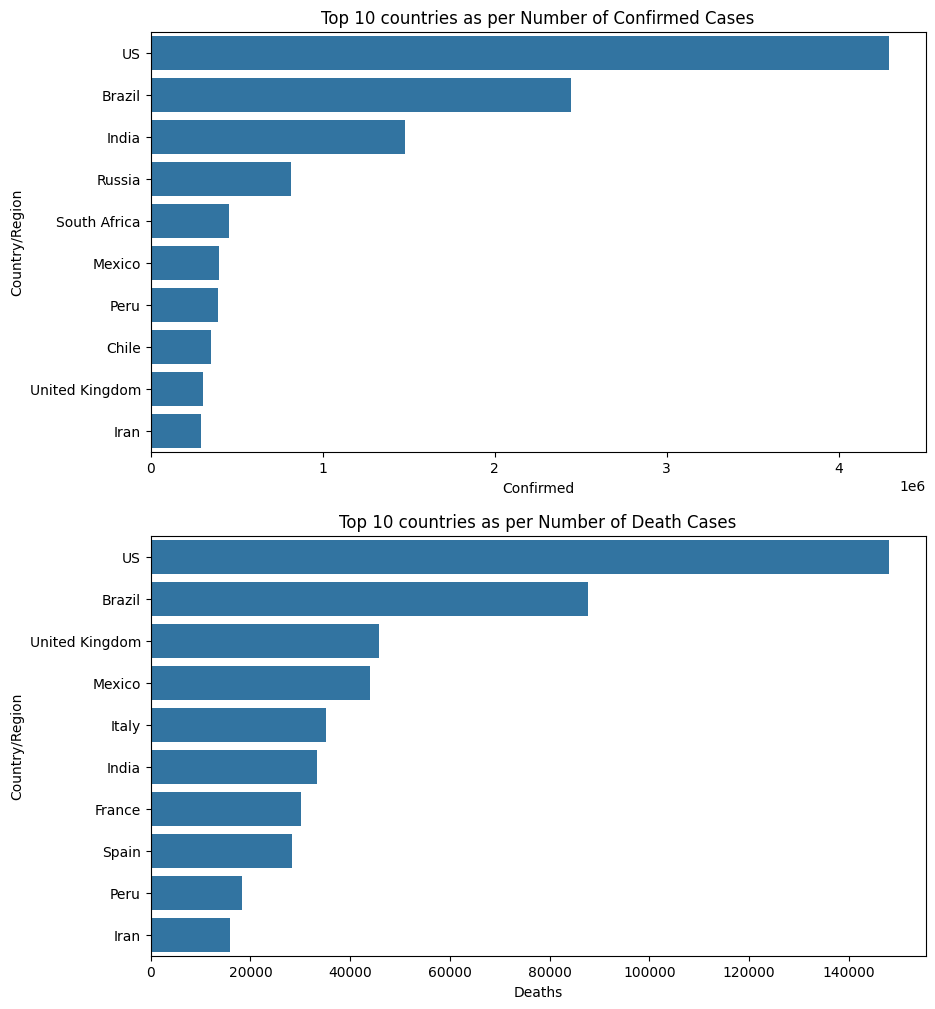

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_10_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(10)
top_10_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(10)
sns.barplot(x=top_10_confirmed["Confirmed"],y=top_10_confirmed.index,ax=ax1)
ax1.set_title("Top 10 countries as per Number of Confirmed Cases")
sns.barplot(x=top_10_deaths["Deaths"],y=top_10_deaths.index,ax=ax2)
ax2.set_title("Top 10 countries as per Number of Death Cases")

Text(0.5, 0, 'Recovery (in Percentage)')

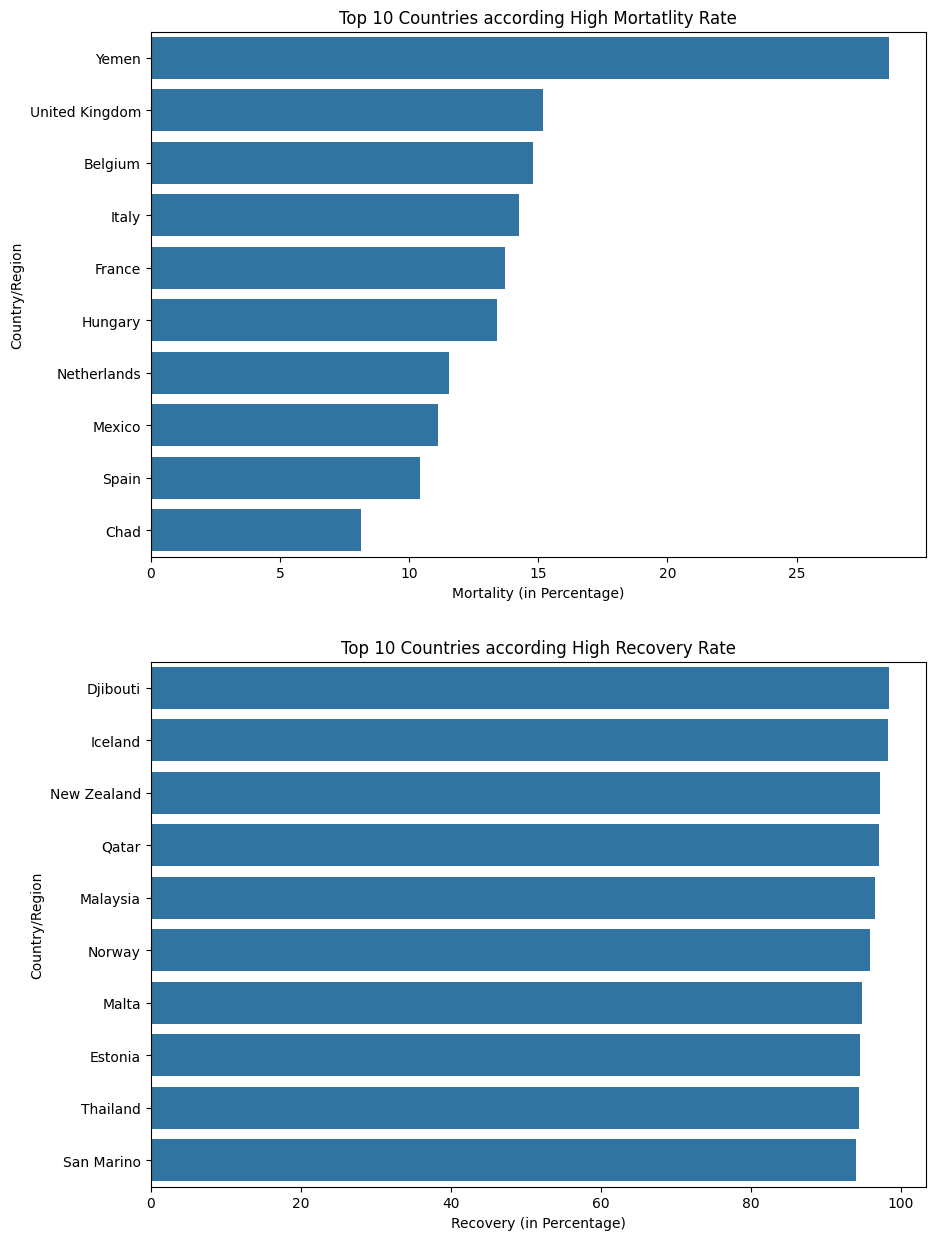

In [40]:
# Top 10 countried with high mortality rate
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).head(10)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 10 Countries according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).head(10)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 10 Countries according High Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

Text(0.5, 1.0, 'Top 15 Countries with Most Number of Closed Cases')

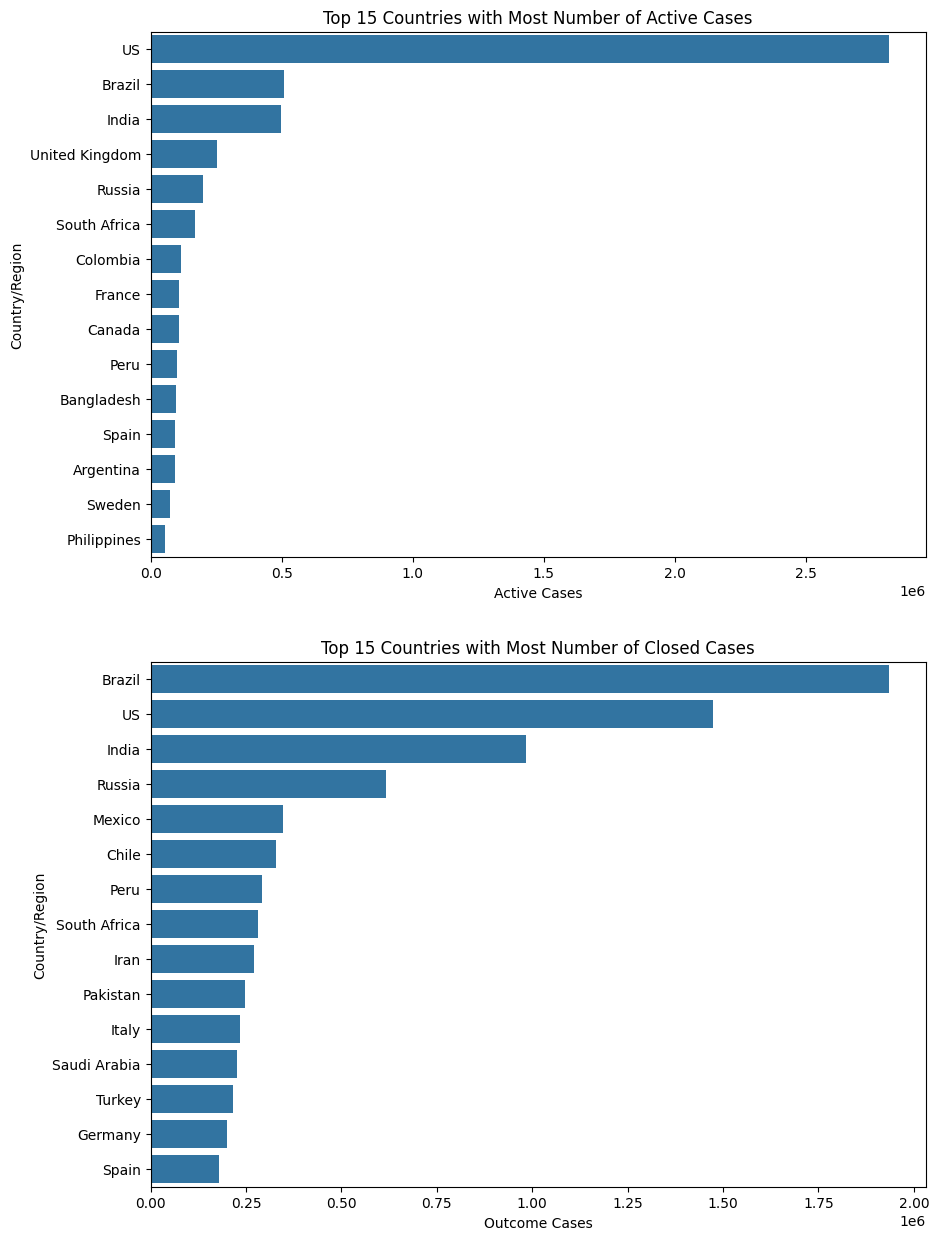

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])
top_10_active=countrywise.sort_values(["Active Cases"],ascending=False).head(15)
top_10_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_10_active["Active Cases"],y=top_10_active.index,ax=ax1)
sns.barplot(x=top_10_outcome["Outcome Cases"],y=top_10_outcome.index,ax=ax2)
ax1.set_title("Top 15 Countries with Most Number of Active Cases")
ax2.set_title("Top 15 Countries with Most Number of Closed Cases")

In [47]:
# cluster different countries based on the Mortality and Recovery rate of indivisual country.

X=countrywise[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
X=std.fit_transform(X)

In [49]:
wcssi=[]
silho=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    silho.append(silhouette_score(X, labels, metric='euclidean'))
    wcssi.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

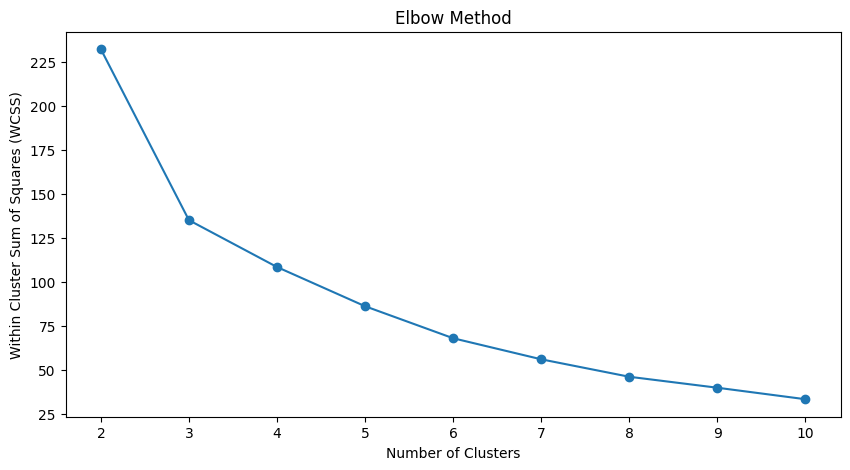

In [50]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcssi,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

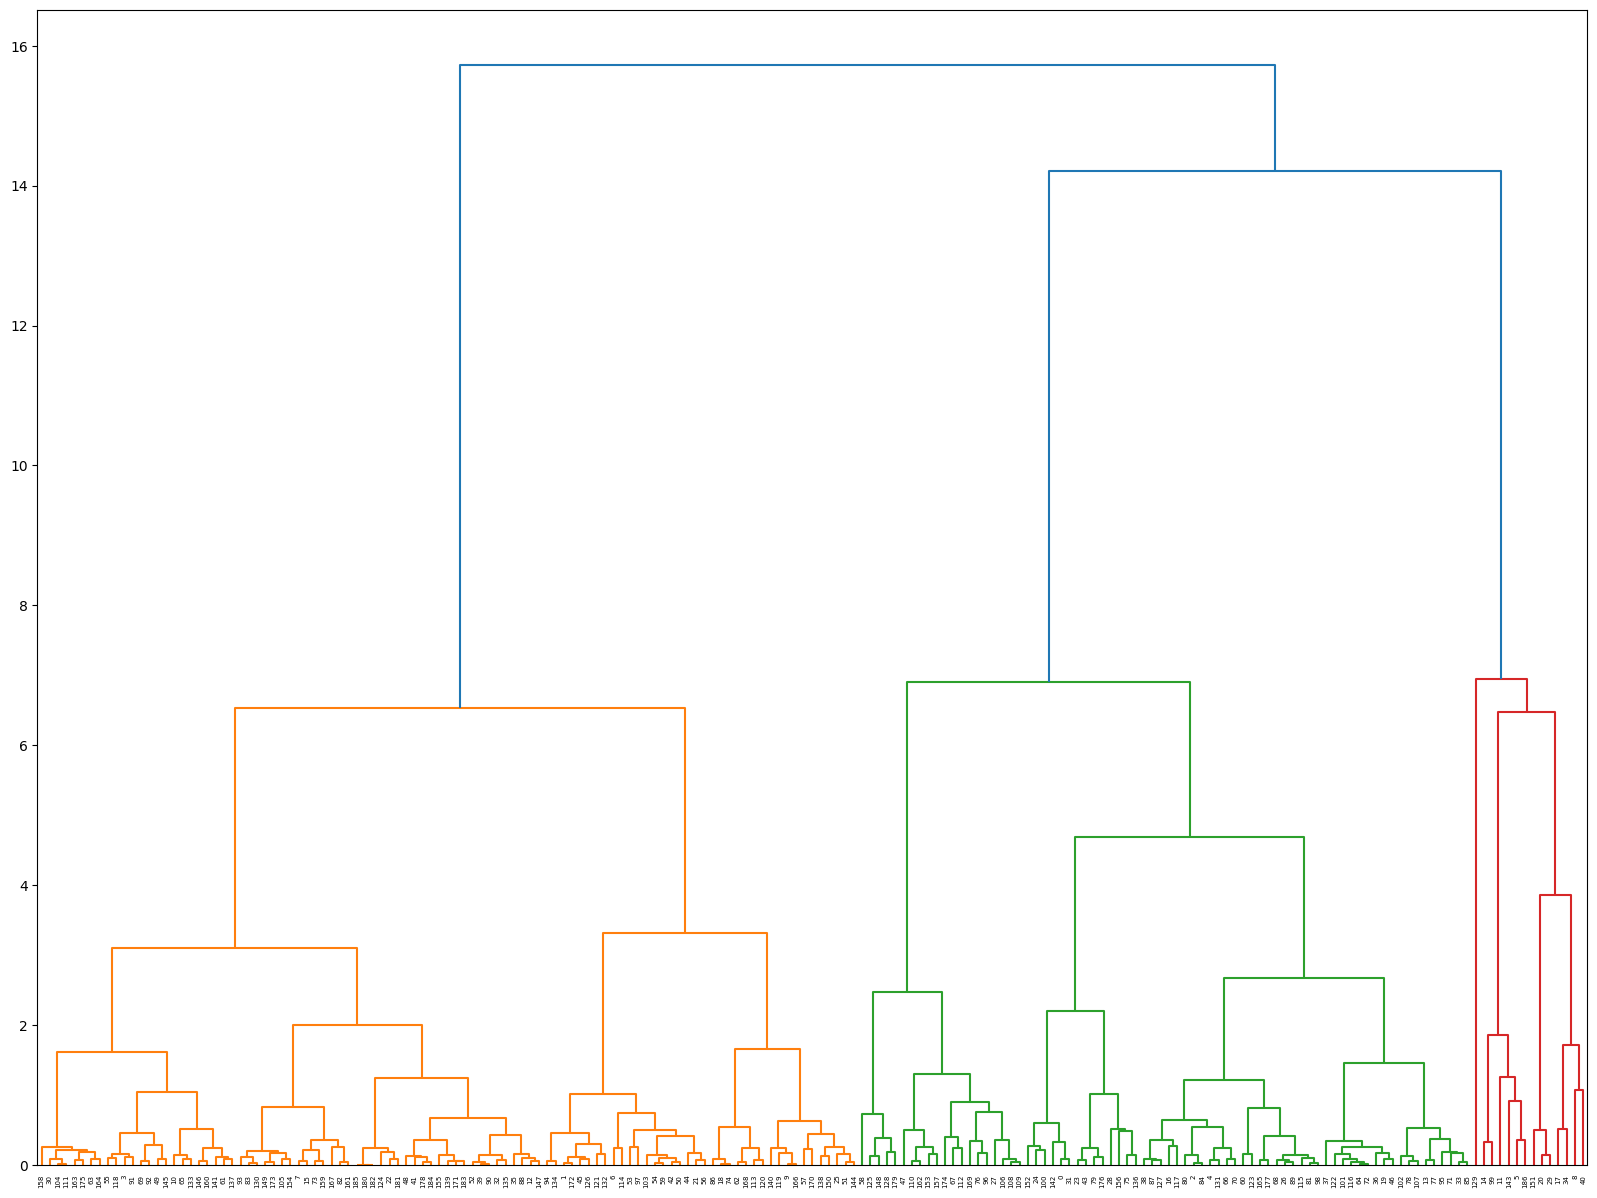

In [51]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

In [52]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(n_clusters=3, random_state=6)

In [53]:
countrywise["Clusters"]=clf_final.predict(X)

In [55]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(10)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Active Cases,Outcome Cases,Clusters
Country/Region,,,,,,,,
US,4290259.00,1325804.00,148011.00,3.45,30.90,2816444.00,1473815.00,1.00
Colombia,257101.00,131161.00,8777.00,3.41,51.02,117163.00,139938.00,1.00
Bangladesh,226225.00,125683.00,2965.00,1.31,55.56,97577.00,128648.00,1.00
Argentina,167416.00,72575.00,3059.00,1.83,43.35,91782.00,75634.00,1.00
Canada,116458.00,0.00,8944.00,7.68,0.00,107514.00,8944.00,1.00
Indonesia,100303.00,58173.00,4838.00,4.82,58.00,37292.00,63011.00,1.00
Egypt,92482.00,34838.00,4652.00,5.03,37.67,52992.00,39490.00,1.00
Philippines,82040.00,26446.00,1945.00,2.37,32.24,53649.00,28391.00,1.00
Ecuador,81161.00,34896.00,5532.00,6.82,43.00,40733.00,40428.00,1.00


In [56]:
#Average mortality, recovery rate of clusters
print("Average Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Average Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Average Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Average Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Average Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Average Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Average Mortality Rate of Cluster 0:  14.301099512835453
Average Recovery Rate of Cluster 0:  48.07149792571852
Average Mortality Rate of Cluster 1:  2.707583315663142
Average Recovery Rate of Cluster 1:  35.55738862965622
Average Mortality Rate of Cluster 2:  2.2149254363429627
Average Recovery Rate of Cluster 2:  81.25850156869187


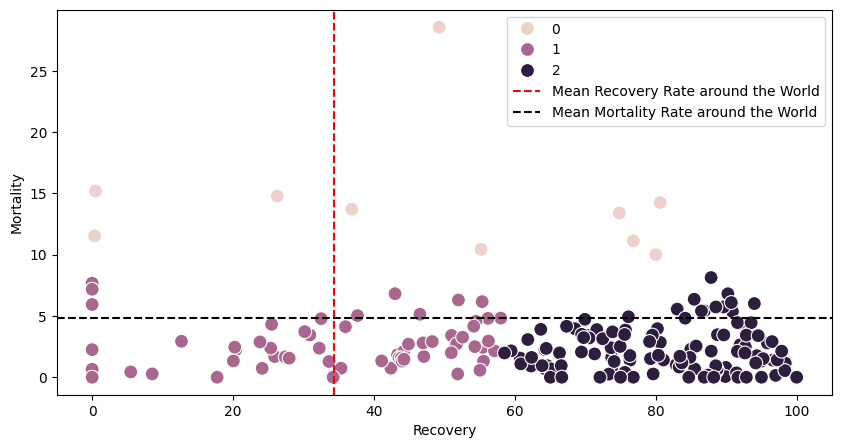

In [58]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise_data["Recovered"]/datewise_data["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise_data["Deaths"]/datewise_data["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [59]:
# 10 counntries belonging to the each cluster

print("10 Countries belonging to Cluster 0: ",list(countrywise[countrywise["Clusters"]==0].head(10).index))
print(" 10 Countries belonging to Cluster 1: ",list(countrywise[countrywise["Clusters"]==1].head(10).index))
print("10 Countries belonging to Cluster 2: ",list(countrywise[countrywise["Clusters"]==2].head(10).index))

10 Countries belonging to Cluster 0:  ['Mexico', 'United Kingdom', 'Spain', 'Italy', 'France', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara']
 10 Countries belonging to Cluster 1:  ['US', 'Colombia', 'Bangladesh', 'Argentina', 'Canada', 'Indonesia', 'Egypt', 'Philippines', 'Ecuador', 'Sweden']
10 Countries belonging to Cluster 2:  ['Brazil', 'India', 'Russia', 'South Africa', 'Peru', 'Chile', 'Iran', 'Pakistan', 'Saudi Arabia', 'Turkey']


In [61]:
# Comparison of China, Italy, US, Spain, Brazil and Rest of the World

china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [62]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [63]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovered"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovered"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovered"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovered"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovered"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovered"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovered Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [64]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Death Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [65]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Confirmed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [66]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Death Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [68]:
# Data for India

india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed    1480073
Recovered     951166
Deaths         33408
Name: 2020-07-27, dtype: int64
Total Active Cases:  495499
Total Closed Cases:  984574


In [69]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [71]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"].diff().fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"].diff().fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [81]:
india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed    1480073
Recovered     951166
Deaths         33408
Name: 2020-07-27, dtype: int64
Total Active Cases:  495499
Total Closed Cases:  984574


In [82]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [83]:
fig=px.bar(x=datewise_india.index,y=datewise_india["Confirmed"]-datewise_india["Recovered"]-datewise_india["Deaths"])
fig.update_layout(title="Active Cases in India",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [84]:
india_increase_confirm=[]
india_increase_recover=[]
india_increase_deaths=[]
for i in range(datewise_india.shape[0]-1):
    india_increase_confirm.append(((datewise_india["Confirmed"].iloc[i+1])/datewise_india["Confirmed"].iloc[i]))
    india_increase_recover.append(((datewise_india["Recovered"].iloc[i+1])/datewise_india["Recovered"].iloc[i]))
    india_increase_deaths.append(((datewise_india["Deaths"].iloc[i+1])/datewise_india["Deaths"].iloc[i]))
india_increase_confirm.insert(0,1)
india_increase_recover.insert(0,1)
india_increase_deaths.insert(0,1)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_confirm,
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_recover,
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_deaths,
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed cases in India",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [85]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"].diff().fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"].diff().fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [98]:
max_ind=datewise_india["Confirmed"].max()

print("It took",datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].shape[0],"days in Italy to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].shape[0],"days in USA to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].shape[0],"days in Spain to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_india[datewise_india["Confirmed"]>0].shape[0],"days in India to reach",max_ind,"Confirmed Cases")

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index, y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index, y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index, y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines',name="India"))
fig.update_layout(title="Growth of Recovered Cases with respect to India",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

It took 179 days in Italy to reach number of Confirmed Cases equivalent to India
It took 116 days in USA to reach number of Confirmed Cases equivalent to India
It took 178 days in Spain to reach number of Confirmed Cases equivalent to India
It took 180 days in India to reach 1480073 Confirmed Cases


In [99]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index,
                         y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index,
                         y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index,
                         y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines',name="India"))
fig.update_layout(title="Daily increase in Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [100]:
#Linear regression model for prediction
datewise_data["Days Since"]=datewise_data.index-datewise_data.index[0]
datewise_data["Days Since"]=datewise_data["Days Since"].dt.days

In [101]:
train_ml=datewise_data.iloc[:int(datewise_data.shape[0]*0.95)]
valid_ml=datewise_data.iloc[int(datewise_data.shape[0]*0.95):]
model_scores=[]

In [110]:
lin_reg=LinearRegression()


In [112]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression()

In [113]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [114]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  4626592.381969578


In [116]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise_data["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_data.index, y=datewise_data["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise_data.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

In [117]:
#svm for prediction
train_ml=datewise_data.iloc[:int(datewise_data.shape[0]*0.95)]
valid_ml=datewise_data.iloc[int(datewise_data.shape[0]*0.95):]

In [118]:
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [119]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, degree=6, epsilon=0.01, kernel='poly')

In [120]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [121]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("RME for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

RME for Support Vectore Machine:  4686932.662801556


In [124]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00


In [130]:
model_train=datewise_data.iloc[:int(datewise_data.shape[0]*0.95)]
valid=datewise_data.iloc[int(datewise_data.shape[0]*0.95):]
y_pred=valid.copy()

In [131]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3775.416, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3777.308, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3769.087, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3762.432, Time=0.15 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3744.519, Time=0.19 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.591 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [132]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [133]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  51306.829833816424


In [134]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [136]:
# SARIMA model for prediction
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore',
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=3720.745, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=3776.211, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=3732.586, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=3742.428, Time=0.09 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=3748.332, Time=0.14 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=3735.744, Time=0.05 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=3721.411, Time=0.53 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=3730.148, Time=0.78 sec
 ARIMA(0,2,0)(0,0,2)[7]             : AIC=3758.800, Time=0.12 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=3728.216, Time=0.10 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=3725.055, Time=0.36 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=3697.229, Time=0.45 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=3749.005, Time=0.08 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=3719.624, Time=0.35 sec
 ARIMA(1,2,0)(1,0,2)[7]          

ARIMA(order=(1, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [137]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [138]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  29311.07251793877


In [139]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [142]:
# Facebook prophet method
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise_data.index),list(datewise_data["Confirmed"])),columns=['ds','y'])

In [143]:
prophet_c.fit(prophet_confirmed)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc5dt0b6z/f2qayykt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc5dt0b6z/1uiolbad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2499', 'data', 'file=/tmp/tmpc5dt0b6z/f2qayykt.json', 'init=/tmp/tmpc5dt0b6z/1uiolbad.json', 'output', 'file=/tmp/tmpc5dt0b6z/prophet_modelliw6v5u3/prophet_model-20240302094956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [144]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [145]:
confirmed_forecast=prophet_c.predict(forecast_c)

In [147]:
model_scores.append(np.sqrt(mean_squared_error(datewise_data["Confirmed"],confirmed_forecast['yhat'].head(datewise_data.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise_data["Confirmed"],confirmed_forecast['yhat'].head(datewise_data.shape[0]))))

Root Mean Squared Error for Prophet Model:  82457.62333070287


Figure(1000x600)


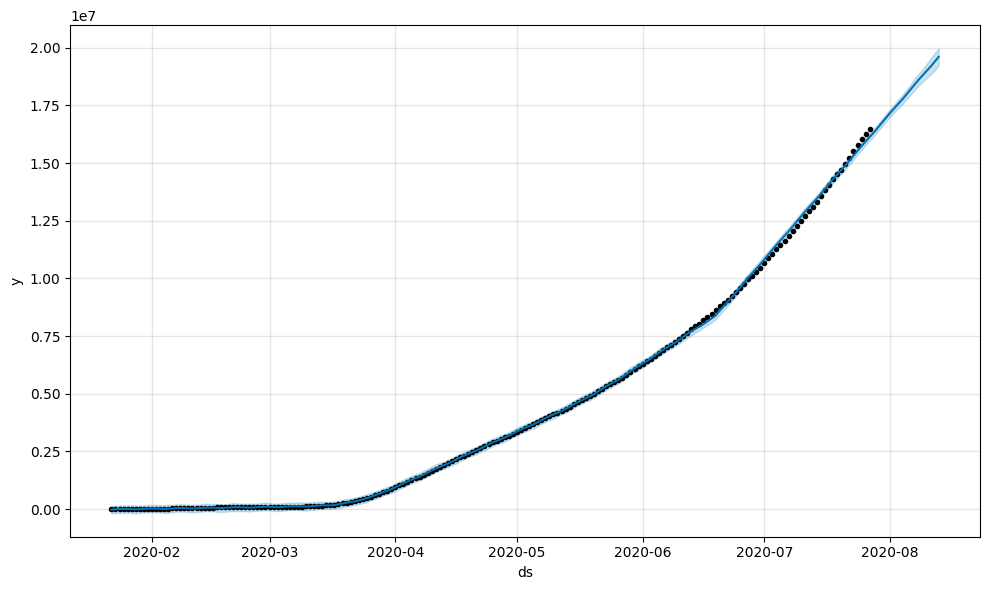

In [148]:
print(prophet_c.plot(confirmed_forecast))

Figure(900x600)


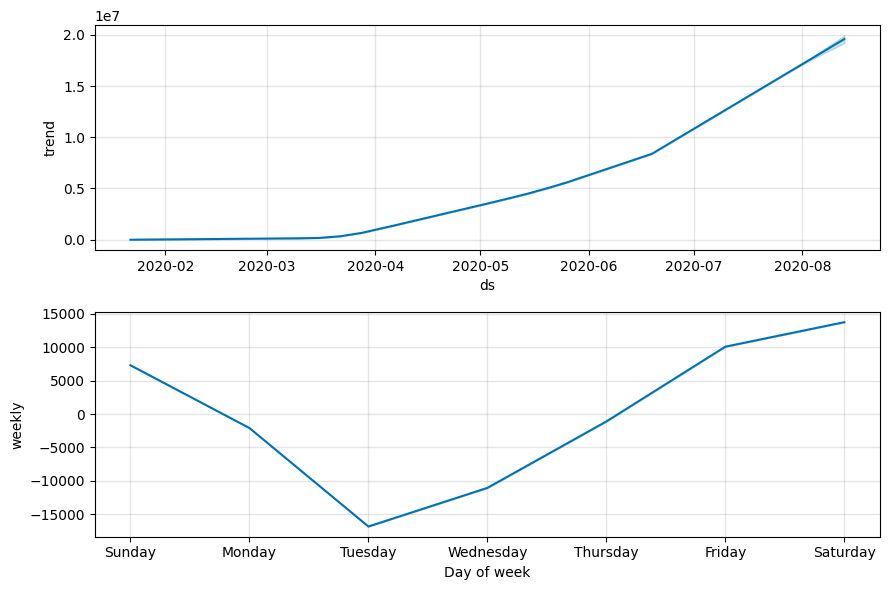

In [149]:
print(prophet_c.plot_components(confirmed_forecast))

In [150]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
3,Holt's Linear,2.931107e+04
2,Support Vector Machine Regressor,5.130683e+04
4,Holt's Winter Model,8.245762e+04
0,Linear Regression,4.626592e+06
1,Polynomial Regression,4.686933e+06


In [151]:
# Time series analysis for death prediction
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [153]:
model_train=datewise_data.iloc[:int(datewise_data.shape[0]*0.95)]
valid=datewise_data.iloc[int(datewise_data.shape[0]*0.95):]
y_pred=valid.copy()

In [154]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima_deaths.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2890.697, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2892.131, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2868.775, Time=0.44 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2868.285, Time=0.96 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=2858.106, Time=1.29 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=2844.013, Time=1.22 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2892.379, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2875.198, Time=0.68 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2869.120, Time=1.03 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2850.328, Time=1.11 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=2843.451, Time=1.38 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2885.867, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2863.920, Time=0.42 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2811.552, Time=0.63 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2796.008, Time=0.69 sec
 ARIMA(3,2

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [155]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [156]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  1249.174242764102


In [157]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [158]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [163]:
new_date=[]
for i in range(1,18):
    new_date.append(datewise_data.index[-1]+timedelta(days=i))

In [162]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2020-07-28,660105.601116
1,2020-07-29,666985.241454
2,2020-07-30,674232.113669
3,2020-07-31,681184.211817
4,2020-08-01,687446.103649
